In [1]:
import re
import json
from pyspark.sql import SparkSession
from operator import add
from pyspark.sql.types import StructType, StructField, StringType, LongType
from pyspark.sql.functions import udf, col, size
from pyspark.sql.types import FloatType, ArrayType
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

spark_session = SparkSession.builder\
        .master("spark://spark-master:7077") \
        .appName("test_run_with_vader")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 16)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/12 15:13:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/12 15:13:38 WARN Utils: Service 'sparkDriver' could not bind on port 9999. Attempting port 10000.
25/03/12 15:13:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/12 15:13:39 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.


In [2]:
DATA_PATH = 'data/reddit.json'
lines = spark_context.textFile(f"hdfs://spark-master:9000/{DATA_PATH}")
parsed_rdd = lines.map(lambda line: json.loads(line))

custom_schema = StructType([
    StructField("content", StringType(), True),          # Comment text
    StructField("summary", StringType(), True),     # Timestamp
    StructField("author", StringType(), True),        # Username
    StructField("subreddit", StringType(), True)      # Subreddit name
])

df = spark_session.createDataFrame(parsed_rdd, schema=custom_schema)

In [3]:
tech_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", "GOOG",  # Alphabet Inc. (Google)
    "AMZN",  # Amazon.com Inc.
    "META",  # Meta Platforms Inc. (Facebook)
    "NVDA",  # NVIDIA Corporation
    "TSLA",  # Tesla Inc.
    "INTC",  # Intel Corporation
    "AMD",  # Advanced Micro Devices Inc.
    "IBM",  # International Business Machines
    "CSCO",  # Cisco Systems Inc.
    "ORCL",  # Oracle Corporation
    "NFLX",  # Netflix Inc.
    "ADBE",  # Adobe Inc.
    "CRM",  # Salesforce Inc.
    "PLTR"  # Palantir Technologies Inc.
]

In [4]:
# Convert the list to a set for faster lookups
tech_tickers_set = set(tech_tickers)

# Define the UDF
def extract_tech_tickers(text):
    import re
    if not text:
        return []
    # Split text into words and clean them
    words = re.findall(r'\b\w+\b', text.upper())  # Split into words, ignoring punctuation
    # Check if cleaned word is in the ticker list
    found_tickers = []
    for word in words:
        cleaned_word = re.sub(r'[^A-Z]', '', word)  # Remove non-alphabetic characters
        if cleaned_word in tech_tickers_set:
            found_tickers.append(cleaned_word)
    return list(set(found_tickers))  # Deduplicate

# Register the UDF
extract_tickers_udf = udf(extract_tech_tickers, ArrayType(StringType()))

In [5]:
# Apply UDF to the "content" column and filter rows with tickers
df = df.withColumn("tickers", extract_tickers_udf(col("content"))) \
       .filter(size(col("tickers")) > 0)

#df.show(5)

In [25]:
# adding wsb/reddit flavour to vader to improve sentiment analysis, score: 4.0 to -4.0
new_words = {
    'citron': -4.0,  
    'hidenburg': -4.0,        
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
    'break': 2.0,
    'tendie': 2.0,
     'tendies': 2.0,
     'town': 2.0,     
     'overvalued': -3.0,
     'undervalued': 3.0,
     'buy': 4.0,
     'sell': -4.0,
     'gone': -1.0,
     'gtfo': -1.7,
     'paper': -1.7,
     'bullish': 3.7,
     'bearish': -3.7,
     'bagholder': -1.7,
     'stonk': 1.9,
     'green': 1.9,
     'money': 1.2,
     'print': 2.2,
     'rocket': 2.2,
     'bull': 4.0,
     'bear': -4.0,
     'pumping': -1.0,
     'sus': -3.0,
     'offering': -2.3,
     'rip': -4.0,
     'downgrade': -3.0,
     'upgrade': 3.0,     
     'maintain': 1.0,          
     'pump': 1.9,
     'hot': 1.5,
     'drop': -2.5,
     'rebound': 1.5,  
     'crack': 2.5,
    'gang': 2.0,
     'scam': -2.0,
    'chamath': -2.0,
     'snake': -2.0,
    'squezze': 3.0,
     'bag': -4.0,
     'fly': 2.0,     
     'way': 2.0,     
     'high': 2.0,
     'volume': 2.5,
     'low': -2.0,
     'trending': 3.0,
     'upwards': 3.0,
     'prediction': 1.0,     
     'cult': -1.0,     
    'big': 2.0,}

In [26]:
analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon.update(new_words)

def custom_sentiment(text):
    if not text:
        return 0.0
    words = text.lower().split()
    positive = sum(1 for word in words if word in positive_words)
    negative = sum(1 for word in words if word in negative_words)
    return (positive - negative) / max(len(words), 1)  # Normalize by text length

def custom_sentiment_vader(text):
    if not text:
        return 0.0
    vs = analyzer.polarity_scores(text)
    return vs['compound']

sentiment_udf = udf(custom_sentiment_vader, FloatType())

In [27]:
df = df.withColumn("sentiment", sentiment_udf(col("content")))

df.show(5)

[Stage 11:>                                                         (0 + 1) / 1]

+--------------------+--------------------+----------------+---------------+-------+---------+
|             content|             summary|          author|      subreddit|tickers|sentiment|
+--------------------+--------------------+----------------+---------------+-------+---------+
|Yeah, but at leas...|all those people ...|         Draoken|leagueoflegends| [META]|  -0.9743|
|Well, your proble...|Try some graphic ...|        Zircon88|      AskReddit|  [AMD]|   0.7273|
|As a mental healt...|Anxiety is about ...| CthulhuFerrigno|       business| [META]|  -0.9121|
|w/o a full time J...|no roaming pressu...|       koochbrah|          Smite| [META]|  -0.5423|
|Who is going to s...|It's a good strat...|TheSystem_IsDown|      investing| [AAPL]|   0.9502|
+--------------------+--------------------+----------------+---------------+-------+---------+
only showing top 5 rows



In [28]:
from pyspark.sql.functions import explode, avg
df_exploded = df.withColumn("ticker", explode(col("tickers")))

df_exploded.show(5)

[Stage 12:>                                                         (0 + 1) / 1]

+--------------------+--------------------+----------------+---------------+-------+---------+------+
|             content|             summary|          author|      subreddit|tickers|sentiment|ticker|
+--------------------+--------------------+----------------+---------------+-------+---------+------+
|Yeah, but at leas...|all those people ...|         Draoken|leagueoflegends| [META]|  -0.9743|  META|
|Well, your proble...|Try some graphic ...|        Zircon88|      AskReddit|  [AMD]|   0.7273|   AMD|
|As a mental healt...|Anxiety is about ...| CthulhuFerrigno|       business| [META]|  -0.9121|  META|
|w/o a full time J...|no roaming pressu...|       koochbrah|          Smite| [META]|  -0.5423|  META|
|Who is going to s...|It's a good strat...|TheSystem_IsDown|      investing| [AAPL]|   0.9502|  AAPL|
+--------------------+--------------------+----------------+---------------+-------+---------+------+
only showing top 5 rows



In [17]:
df.count()

30179

In [16]:
df_exploded.count()

30302

In [29]:
# average the scores
scores_df = df_exploded.groupBy("ticker").agg(avg("sentiment").alias("avg_sentiment"))

# transform to dictionary
scores = {row["ticker"]: row["avg_sentiment"] for row in scores_df.collect()}

print(scores)

[Stage 15:>                                                         (0 + 1) / 1]

{'AAPL': 0.5836389836997299, 'META': 0.5297901868084792, 'NFLX': 0.5964411812670091, 'IBM': 0.5179890592761042, 'GOOGL': 0.1990650027990341, 'AMD': 0.501339153038441, 'MSFT': 0.601711627236719, 'CRM': 0.6178565219941745, 'GOOG': 0.5116988465018656, 'TSLA': 0.7375812468429407, 'INTC': 0.9812666773796082, 'NVDA': 0.8032249882817268, 'AMZN': 0.7046749964356422, 'ADBE': 0.1604500114917755, 'CSCO': -0.20226001739501953, 'ORCL': 0.9957999885082245}


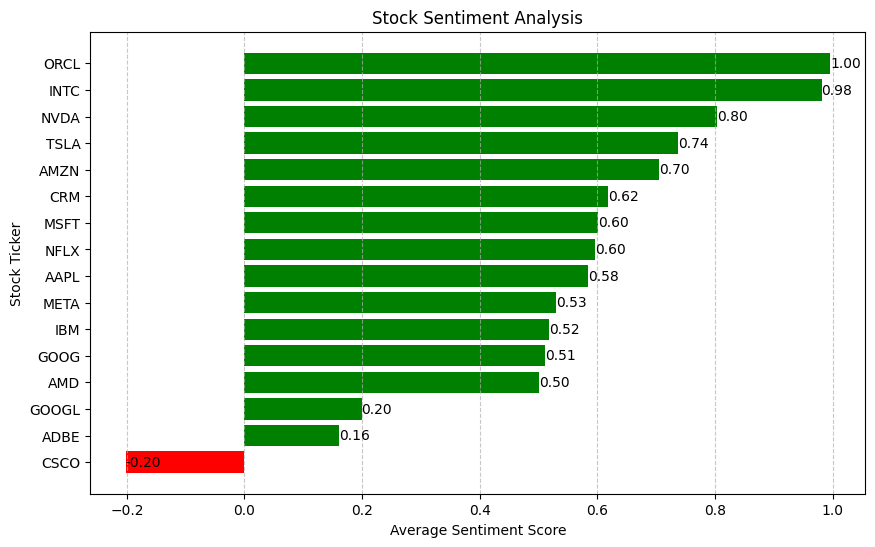

In [30]:
import matplotlib.pyplot as plt
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1]))

# extract tickers and the corresponding score
tickers = list(sorted_scores.keys())
sentiments = list(sorted_scores.values())

# positive: green, negtive: red
colors = ["green" if score > 0 else "red" for score in sentiments]

# plot bar graph
plt.figure(figsize=(10, 6))
bars = plt.barh(tickers, sentiments, color=colors)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=10)

plt.xlabel("Average Sentiment Score")
plt.ylabel("Stock Ticker")
plt.title("Stock Sentiment Analysis")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [31]:
spark_session.stop()